In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
CLASSES = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5), (0.5))
])

In [7]:
train_dataset = torchvision.datasets.FashionMNIST(root='~/assignment2datasets', train = True, transform=transform, download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='~/assignment2datasets', train = False, transform=transform, download=True)

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size= 16, shuffle = True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 16, shuffle = False)

In [9]:
input_size = 784
hidden_size = 400
CLASSES =10

class FCN(nn.Module):
    def __init__(self):
        super(FCN,self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,CLASSES)

    def forward(self,x):
        x = x.view(-1,input_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
model = FCN().to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [12]:
def train(model,device,train_loader,optimizer,epochs):
    print("inside train")
    model.train()

    running_loss = 0
    y_actual = 0
    total = 0

    for batch_ids, (img, classes) in enumerate(train_loader):
        classes=classes.type(torch.LongTensor)
        img,classes=img.to(device),classes.to(device)    
        optimizer.zero_grad()
        output=model(img)
        loss = loss_fn(output,classes)                
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,y_predicted = torch.max(output, 1)
        y_actual += (y_predicted == classes).sum().item()
        total += classes.size(0)

        if(batch_ids +1) % 8 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
            epochs, batch_ids* len(img), len(train_loader.dataset),
            100.*batch_ids / len(train_loader),loss.item()))

    avg_loss = running_loss / len(train_loader)
    return avg_loss

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss=0
    correct=0
    total = 0

    with torch.no_grad():
        for img,classes in test_loader:
            img,classes=img.to(device), classes.to(device)
            
            y_hat=model(img)
            loss = loss_fn(y_hat, classes)
            test_loss += loss.item()

            _,y_pred=torch.max(y_hat,1)
            correct+=(y_pred==classes).sum().item()
            total += classes.size(0)
            
        accuracy = 100 * correct / total

        # Print results
        print("\nTest set: Accuracy: {}/{} ({:.0f}%)\n".format(
        correct, total, accuracy))
        print('='*30)

        return accuracy

In [14]:
train_loss_values = []
test_accuracy_values = []

if __name__=='__main__':
    seed=42
    EPOCHS=5
    
    for epoch in range(1,EPOCHS+1):
        avg_loss = train(model, device, train_loader, optimizer, epoch)
        train_loss_values.append(avg_loss)
        test_accuracy = test(model, device, test_loader)
        test_accuracy_values.append(test_accuracy)

inside train
Train Epoch: 1 [112/60000 (0%)]	Loss: 2.051529
Train Epoch: 1 [240/60000 (0%)]	Loss: 1.276166
Train Epoch: 1 [368/60000 (1%)]	Loss: 0.959587
Train Epoch: 1 [496/60000 (1%)]	Loss: 1.552498
Train Epoch: 1 [624/60000 (1%)]	Loss: 0.974141
Train Epoch: 1 [752/60000 (1%)]	Loss: 1.335513
Train Epoch: 1 [880/60000 (1%)]	Loss: 0.897268
Train Epoch: 1 [1008/60000 (2%)]	Loss: 1.442776
Train Epoch: 1 [1136/60000 (2%)]	Loss: 0.662349
Train Epoch: 1 [1264/60000 (2%)]	Loss: 1.608075
Train Epoch: 1 [1392/60000 (2%)]	Loss: 0.421700
Train Epoch: 1 [1520/60000 (3%)]	Loss: 0.315436
Train Epoch: 1 [1648/60000 (3%)]	Loss: 0.950615
Train Epoch: 1 [1776/60000 (3%)]	Loss: 1.099226
Train Epoch: 1 [1904/60000 (3%)]	Loss: 0.678375
Train Epoch: 1 [2032/60000 (3%)]	Loss: 0.503007
Train Epoch: 1 [2160/60000 (4%)]	Loss: 1.005825
Train Epoch: 1 [2288/60000 (4%)]	Loss: 0.687961
Train Epoch: 1 [2416/60000 (4%)]	Loss: 0.613325
Train Epoch: 1 [2544/60000 (4%)]	Loss: 1.197703
Train Epoch: 1 [2672/60000 (4%)]	L

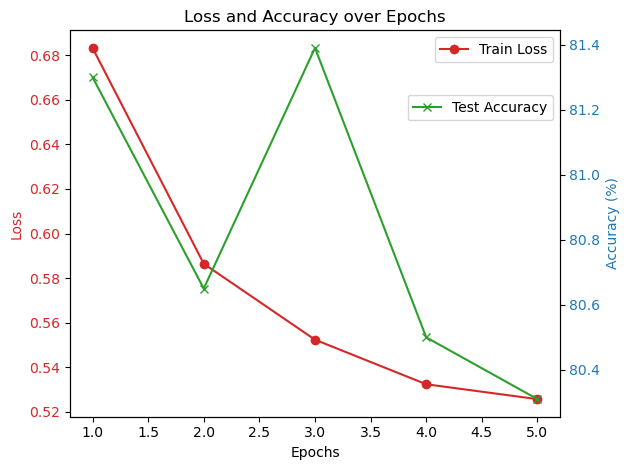

[0.6833035511771838, 0.5864444486260414, 0.5523685458265245, 0.5323859701683124, 0.5256966790077587]
[81.3, 80.65, 81.39, 80.5, 80.31]


In [28]:
# Plotting loss and accuracy
fig, ax1 = plt.subplots()

# Plot training and test loss
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(range(1, EPOCHS + 1), train_loss_values, label='Train Loss', color='tab:red', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(range(1, EPOCHS + 1), test_accuracy_values, label='Test Accuracy', color='tab:green', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add title and legends
plt.title('Loss and Accuracy over Epochs')
ax1.legend(loc='upper right', ncol=1)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.85), ncol=1)
fig.tight_layout()
plt.show()

print (train_loss_values)
print (test_accuracy_values)